# Theory - Normal Latent Prior and Uniform Kernel

- Prior $p(\xi) = \mathcal{N}(0, \mathrm{I})$
    - $\theta\sim \mathcal{N}(0, 1)$ parameter prior
    - $u\sim\mathcal{N}(0, 1)$ latent prior
- Simulator $y = \log\mathcal{N}(\xi \mid \mu, \Sigma)$ 
- Target posterior $p_\epsilon(\xi\mid y^*) \propto p(\xi) \mathbb{I}[\|f(\xi)-y^*\|\leq \epsilon]$ where $p(\xi)$ joint parameter and latent prior.

$$
\text{RMSE}(f(\xi^{(1:N)}), y^*)
$$

Assume diagonal covariance matrix $\Sigma = \rho\text{diag}(\lambda_1, \lambda_2)$ so that $|\Sigma| = \rho^2\lambda_1\lambda_2$ and $\Sigma^{-1} = \rho^{-1}\text{diag}(\lambda_1^{-1}, \lambda_2^{-1})$ and $\mu=(0,0)^\top$.

The parameter posterior can be found by integrating
$$
\begin{align}
    p_\epsilon(\theta\mid y^*)
    &\propto p(\theta) \int_{\|f(\xi)-y^*\|\leq \epsilon} p(u) du \\
    &\propto p(\theta) \frac{1}{\sqrt{2\pi}} \int_{a(\theta)\leq -\frac{u^2}{2} \leq b(\theta)} e^{-\frac{u^2}{2}} du \\
    &= \frac{p(\theta)}{2\sqrt{2}} \left[\frac{2}{\sqrt{\pi}}\int_{\sqrt{-2b(\theta)}}^{\sqrt{-2a(\theta)}} e^{-\frac{u^2}{2}}du + \frac{2}{\sqrt{\pi}}\int_{-\sqrt{-2a(\theta)}}^{-\sqrt{-2b(\theta)}} e^{-\frac{u^2}{2}}du\right] \\
    &= \frac{p(\theta)}{2} \left[\frac{2}{\sqrt{\pi}}\int_{\sqrt{-b(\theta)}}^{\sqrt{-a(\theta)}}e^{-t^2} dt + \frac{2}{\sqrt{\pi}}\int_{-\sqrt{-a(\theta)}}^{-\sqrt{-b(\theta)}} e^{-t^2}dt\right] \\
    &= \frac{p(\theta)}{2} \left[\text{erf}(\sqrt{-a(\theta}) - \text{erf}(\sqrt{-b(\theta)}) + \text{erf}(-\sqrt{-b(\theta)}) - \text{erf}(-\sqrt{-a(\theta)})\right] \\
    &= p(\theta)\left[\text{erf}(\sqrt{-a(\theta)}) - \text{erf}(\sqrt{-b(\theta)})\right]
\end{align}
$$

where
<!-- $$
\begin{align}
a(\theta) &= \frac{\theta^2\lambda_2}{2\lambda_1} + \lambda_2\rho\log(2\pi|\rho|\sqrt{\lambda_1\lambda_2}(y^*-\epsilon)) \\
b(\theta) &= \frac{\theta^2\lambda_2}{2\lambda_1} + \lambda_2\rho\log(2\pi|\rho|\sqrt{\lambda_1\lambda_2}(y^*+\epsilon))
\end{align}
$$ -->
$$
\begin{align}
    a(\theta) &= \rho \lambda_2(z^*-\epsilon + \log(2\pi |\rho|\sqrt{\lambda_1\lambda_2})) + \frac{\theta^2\lambda_2}{2\lambda_1} \\
    b(\theta) &= \rho \lambda_2(z^*+\epsilon + \log(2\pi |\rho|\sqrt{\lambda_1\lambda_2})) + \frac{\theta^2\lambda_2}{2\lambda_1}
\end{align}
$$

Alternatively one can also find 
$$
p_\epsilon(\theta\mid y^*) \propto 2p(\theta) \left[\Phi(\sqrt{-2a(\theta)}) - \Phi(\sqrt{-2b(\theta)})\right]\qquad\qquad \Phi \text{ normal CDF }
$$

### Settings

In [1]:
import numpy as np
from numpy import zeros, diag, eye, log, pi, sqrt, vstack, exp, mean, load
from numpy.linalg import solve
from scipy.stats import multivariate_normal as MVN
from tangential_hug_functions import Hug, HugTangential, GradientHug, Hop, run_hug_hop, run_thug_hop
from utils import ESS, quick_MVN_scatter, prep_contour, quick_MVN_marginals
import matplotlib.pyplot as plt
from scipy.stats import norm as ndist
from numpy.random import uniform, normal
from scipy.special import gammaincc
from scipy.special import gamma, erf
import tensorflow_probability as tfp
from scipy.optimize import root
from utils import ESS_univariate, box_plot
from IPython.display import display, Latex

In [2]:
# Target distribution is a diagonal MVN
Sigma0 = diag([1.0, 5.0])
rho = 1.0
Sigma = rho * Sigma0
target = MVN(zeros(2), Sigma)

# Initial point on z0-contour
x0 = normal(size=2)
z0 = target.logpdf(x0)      

# Proposal for velocity in HUG/THUG
q = MVN(zeros(2), eye(2))

In [3]:
# Settings
epsilon = 0.0001
T = 2.0
B = 5
N = 50000
alpha = 0.99
k = 0.25

In [4]:
def a(theta):
    l1, l2 = Sigma0[0, 0], Sigma0[1, 1]
    return rho*l2*(z0 - epsilon + log(2*pi*abs(rho)*sqrt(l1*l2))) + (theta**2)*l2 / (2*l1)

def b(theta):
    l1, l2 = Sigma0[0, 0], Sigma0[1, 1]
    return rho*l2*(z0 + epsilon + log(2*pi*abs(rho)*sqrt(l1*l2))) + (theta**2)*l2 / (2*l1)

def posterior(theta):
    """Closed-form posterior distribution."""
    return ndist.pdf(theta) * (erf(sqrt(-a(theta))) - erf(sqrt(-b(theta))))

def log_uniform_kernel(xi):
    """Log density of uniform kernel. """
    with np.errstate(divide='ignore'):
        return log(abs(target.logpdf(xi) - z0) <= epsilon)
    
def logprior_normal(xi):
    """Log density for normal prior p(xi) of parameters and latents N(0, I)."""
    return MVN(zeros(2), eye(2)).logpdf(xi)
    
def log_abc_posterior(xi):
    """Log density of ABC posterior. Product of (param-latent) prior and uniform kernel."""
    return logprior_normal(xi) + log_uniform_kernel(xi)
    
def grad_log_simulator(xi):
    """Gradient of log simulator N(mu, Sigma)."""
    return - solve(Sigma, xi)

def mcmc_abc(x0, N):
    theta0 = x0[0]
    samples = theta = theta0
    acceptances = np.zeros(N)
    us = normal(size=N).reshape(-1,1)
    for i in range(N):
        theta_new = normal()                     # Sample from the parameter prior
        z = target.logpdf([theta_new, us[i]]) # Feed through simulator
        if abs(z - z0) <= epsilon:
            # Compute MCMC acceptance ratio
            a = ndist.pdf(theta_new) * ndist.pdf(theta_new) / (ndist.pdf(theta) * ndist.pdf(theta))
            if uniform() <= a:
                theta = theta_new
                acceptances[i] = 1
        samples = vstack((samples, theta))
    return samples[1:], acceptances, us

### HUG vs THUG vs MCMC-ABC

In [5]:
hug, ahug  = Hug(x0, T, B, N, q, log_abc_posterior, grad_log_simulator)

In [6]:
thug, athug = HugTangential(x0, T, B, N, alpha, q, log_abc_posterior, grad_log_simulator)

In [10]:
mcmc, amcmc, umcmc = mcmc_abc(x0, N)

In [11]:
xlims = min(np.min(hug[:, 0]), np.min(thug[:, 0]))*1.2, max(np.max(hug[:, 0]), np.max(thug[:, 0]))*1.2
ylims = min(np.min(hug[:, 1]), np.min(thug[:, 1]))*1.2, max(np.max(hug[:, 1]), np.max(thug[:, 1]))*1.2

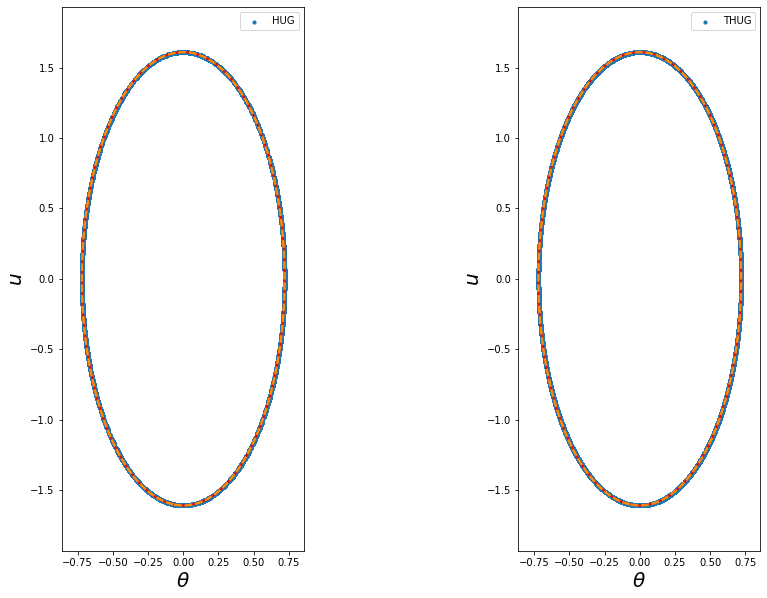

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))
ax[0].contour(*prep_contour(xlims, ylims, 0.01, target.pdf), levels=[exp(z0)], linewidths=2, colors='red')
ax[0].contour(*prep_contour(xlims, ylims, 0.01, target.pdf), levels=[exp(z0-epsilon), exp(z0+epsilon)], linewidths=2, colors='darkorange', linestyles='--')
ax[0].scatter(*hug.T, s=10, label='HUG')
ax[0].legend()
ax[0].set_aspect("equal")
ax[0].set_xlabel("$\\theta$", fontsize=20)
ax[0].set_ylabel("$u$", fontsize=20)
ax[1].contour(*prep_contour(xlims, ylims, 0.01, target.pdf), levels=[exp(z0)], linewidths=2, colors='red')
ax[1].contour(*prep_contour(xlims, ylims, 0.01, target.pdf), levels=[exp(z0-epsilon), exp(z0+epsilon)], linewidths=2, colors='darkorange', linestyles='--')
ax[1].scatter(*thug.T, s=10, label='THUG')
ax[1].legend()
ax[1].set_aspect("equal")
ax[1].set_xlabel("$\\theta$", fontsize=20)
ax[1].set_ylabel("$u$", fontsize=20)
plt.show()

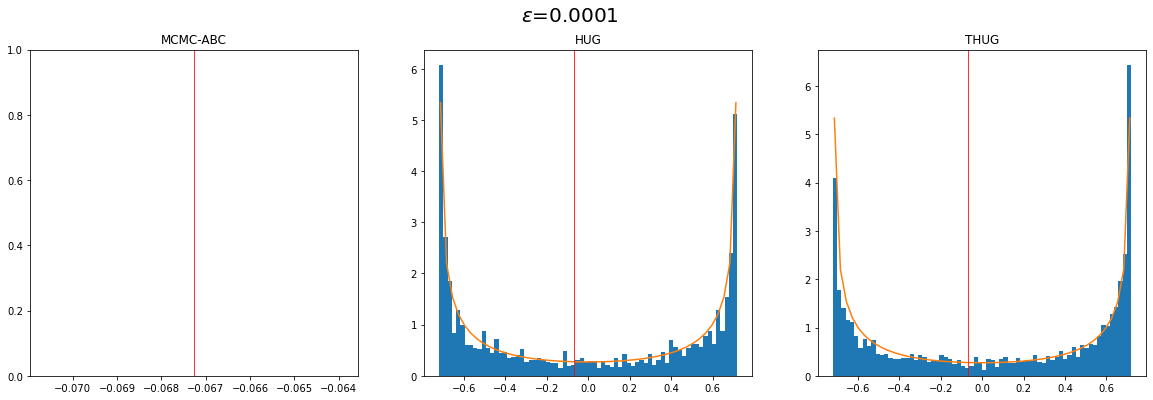

In [13]:
norm_const = 5000
top = np.max(hug[:, 0])*0.99
vals = np.linspace(-top, top) 
fig, ax = plt.subplots(ncols=3, figsize=(20, 6))

#_ = ax[0].hist(mcmc[:, 0], bins=70, density=True)
#ax[0].plot(vals, norm_const*posterior(vals))
ax[0].set_title("MCMC-ABC")
ax[0].axvline(x0[0], color='red', linewidth=0.8)

_ = ax[1].hist(hug[:, 0], bins=70, density=True)
ax[1].plot(vals, norm_const*posterior(vals))
ax[1].set_title("HUG")
ax[1].axvline(x0[0], color='red', linewidth=0.8)

_ = ax[2].hist(thug[:, 0], bins=70, density=True)
ax[2].plot(vals, norm_const*posterior(vals))
ax[2].set_title("THUG")
ax[2].axvline(x0[0], color='red', linewidth=0.8)
fig.suptitle("$\\epsilon$={}".format(epsilon), fontsize=20)
plt.show()

In [14]:
mcmc_xi = np.hstack((mcmc, umcmc))

In [15]:
display(Latex('ESS for $\\theta$ chain'))
print("-"*25)
print("HUG:       {:.6}".format(ESS_univariate(hug[:, 0])))
print("THUG:      {:.6}".format(ESS_univariate(thug[:, 0])))
print("MCMC-ABC:  {:.6}".format(ESS_univariate(mcmc.flatten())))
print("\n")
print("\n")
display(Latex('ESS for $\log p_{\epsilon}(\\xi\mid y^*)$ chain'))
print("-"*25)
print("HUG:      {:.6}".format(ESS_univariate(log_abc_posterior(hug))))
print("THUG:     {:.6}".format(ESS_univariate(log_abc_posterior(thug))))
print("MCMC-ABC: {:.6}".format(ESS_univariate(log_abc_posterior(mcmc_xi))))
print("\n")
print("\n")
display(Latex('Acceptance Probabilities'))
print("HUG:      {:.2%}".format(mean(ahug)))
print("THUG:     {:.2%}".format(mean(athug)))
print("MCMC-ABC: {:.2%}".format(mean(amcmc)))
print("\n")
print("\n")
display(Latex('RMSE'))
print("HUG:      {:.4}".format(sqrt(mean((target.logpdf(hug) - z0)**2))))
print("THUG:     {:.4}".format(sqrt(mean((target.logpdf(thug) - z0)**2))))
print("MCMC-ABC: {:.4}".format(sqrt(mean((target.logpdf(mcmc_xi) - z0)**2))))

<IPython.core.display.Latex object>

-------------------------
HUG:       107.702
THUG:      69.2295
MCMC-ABC:  6.81706






<IPython.core.display.Latex object>

-------------------------
HUG:      253.767
THUG:     121.754
MCMC-ABC: nan






<IPython.core.display.Latex object>

HUG:      6.53%
THUG:     19.74%
MCMC-ABC: 0.02%






<IPython.core.display.Latex object>

HUG:      5.751e-05
THUG:     5.761e-05
MCMC-ABC: 0.1768


In [16]:
ESS_HUG = load("experiment11/ESS_HUG.npy")
ESS_LOGPI_HUG = load("experiment11/ESS_LOGPI_HUG.npy")
A_HUG = load("experiment11/A_HUG.npy")
RMSE_HUG = load("experiment11/RMSE_HUG.npy")

ESS_THUG = load("experiment11/ESS_THUG.npy")
ESS_LOGPI_THUG = load("experiment11/ESS_LOGPI_THUG.npy")
A_THUG = load("experiment11/A_THUG.npy")
RMSE_THUG = load("experiment11/RMSE_THUG.npy")

EPSILONS = load("experiment11/EPSILONS.npy")
ALPHAS = load("experiment11/ALPHAS.npy")

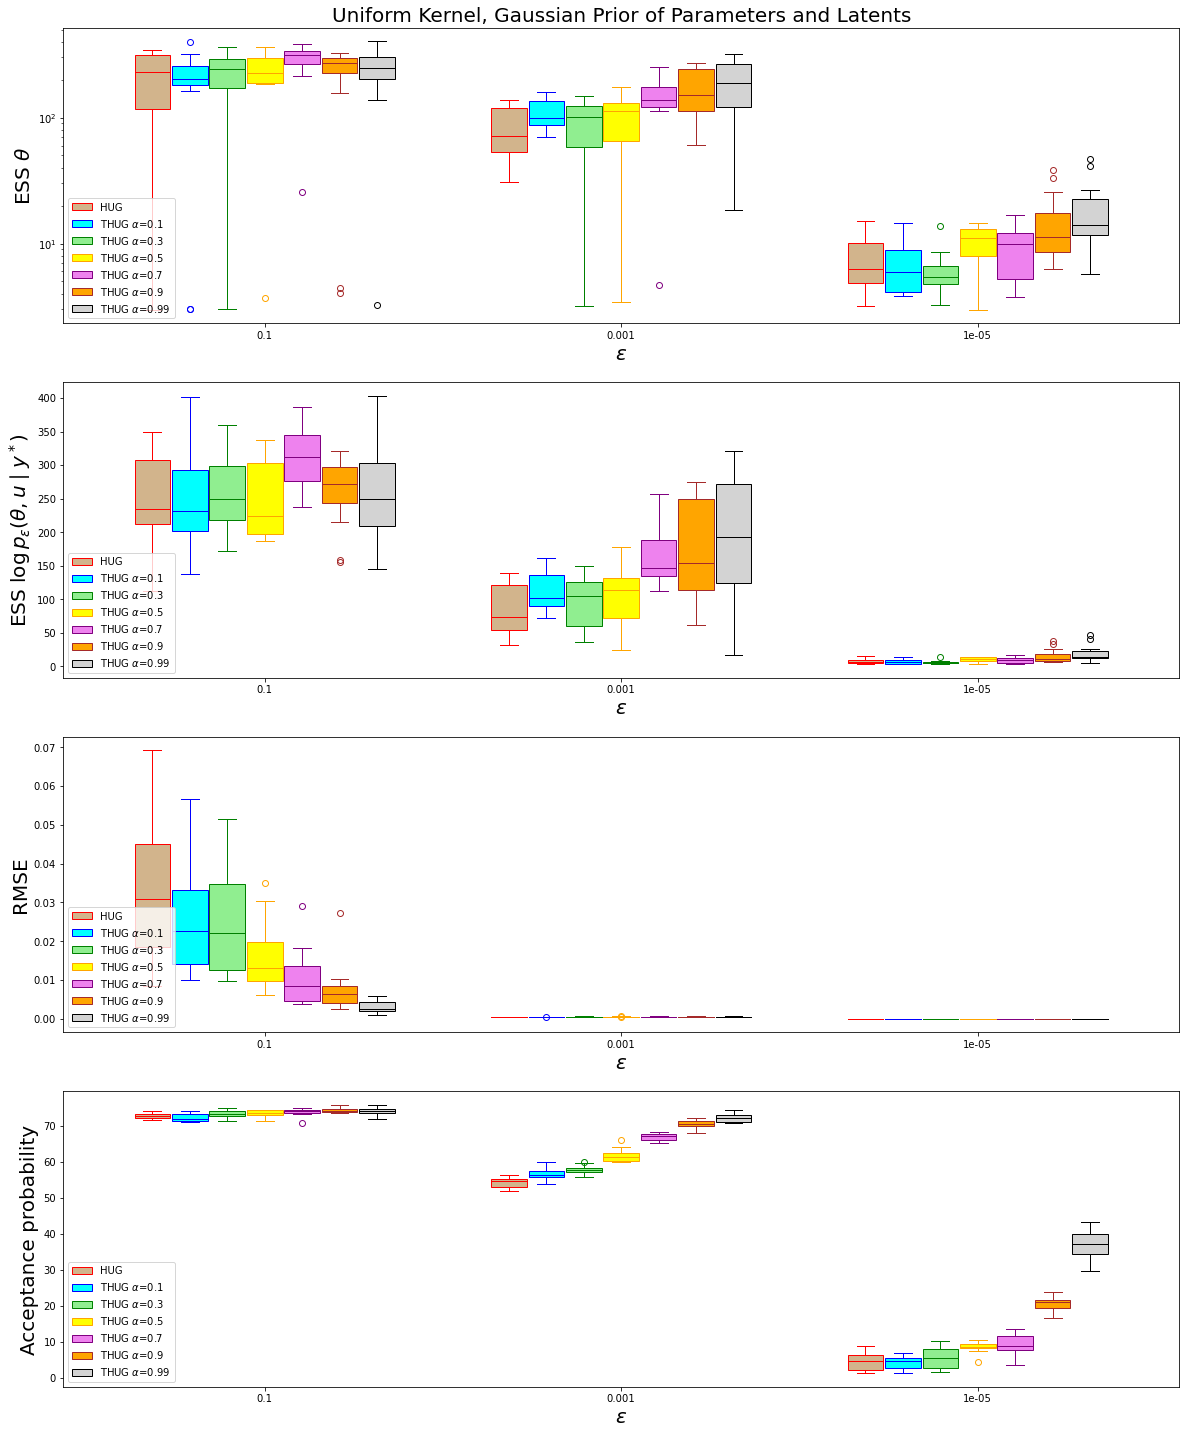

In [19]:
columns = EPSILONS
width = 0.21
n_alphas = len(ALPHAS)
ticks = np.arange(start=1, stop=len(EPSILONS)*2, step=2)
n_boxes = n_alphas + 1
disp = np.linspace(-width * (n_boxes-1) / 2, width * (n_boxes-1) / 2, n_boxes, endpoint=True)
positions = disp.reshape(-1, 1) + ticks
colors1 = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black']
colors2 = ['tan', 'cyan', 'lightgreen', 'yellow', 'violet', 'orange', 'lightgray']

fig, ax = plt.subplots(nrows=4, figsize=(20, 25))
# Univariate ESS for \theta chain
bp1 = box_plot(ax[0], ESS_HUG.T.tolist(), 'red', 'tan', positions[0])
bps = []
for i in range(len(ALPHAS)):
    bps.append(box_plot(ax[0], ESS_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
handles = [bp1["boxes"][0]] + [bp["boxes"][0] for bp in bps]
labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
ax[0].legend(
    handles, 
    labels, 
    loc='lower left')
ax[0].set_xticks(ticks)
ax[0].set_xticklabels(columns)
ax[0].set_xlabel("$\\epsilon$", fontsize=20)
ax[0].set_ylabel("ESS $\\theta$", fontsize=20)
ax[0].semilogy()

# ESS for joint ABC posterior
bp1_joint = box_plot(ax[1], ESS_LOGPI_HUG.T.tolist(), 'red', 'tan', positions[0])
bps_joint = []
for i in range(len(ALPHAS)):
    bps_joint.append(box_plot(ax[1], ESS_LOGPI_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
handles = [bp1_joint["boxes"][0]] + [bp["boxes"][0] for bp in bps_joint]
labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
ax[1].legend(
    handles, 
    labels, 
    loc='lower left')
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(columns)
ax[1].set_xlabel("$\\epsilon$", fontsize=20)
ax[1].set_ylabel("ESS $\log p_{\\epsilon}(\\theta, u \mid y^*)$", fontsize=20)
#ax[1].semilogy()

# RMSE 
bp1_rmse = box_plot(ax[2], RMSE_HUG.T.tolist(), 'red', 'tan', positions[0])
bps_rmse = []
for i in range(len(ALPHAS)):
    bps_rmse.append(box_plot(ax[2], RMSE_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
handles = [bp1_rmse["boxes"][0]] + [bp["boxes"][0] for bp in bps_rmse]
labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
ax[2].legend(
    handles, 
    labels, 
    loc='lower left')
ax[2].set_xticks(ticks)
ax[2].set_xticklabels(columns)
ax[2].set_xlabel("$\\epsilon$", fontsize=20)
ax[2].set_ylabel("RMSE", fontsize=20)
# ax[2].semilogy()

# ACCEPTANCE PROBABILITY 
bp1_a = box_plot(ax[3], A_HUG.T.tolist(), 'red', 'tan', positions[0])
bps_a = []
for i in range(len(ALPHAS)):
    bps_a.append(box_plot(ax[3], A_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
handles = [bp1_a["boxes"][0]] + [bp["boxes"][0] for bp in bps_a]
labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
ax[3].legend(
    handles, 
    labels, 
    loc='lower left')
ax[3].set_xticks(ticks)
ax[3].set_xticklabels(columns)
ax[3].set_xlabel("$\\epsilon$", fontsize=20)
ax[3].set_ylabel("Acceptance probability", fontsize=20)
# ax[3].semilogy()

ax[0].set_title("Uniform Kernel, Gaussian Prior of Parameters and Latents", fontsize=20)
plt.show()

In [7]:
A_HUG.mean(axis=0)

array([72.85      , 54.2125    ,  4.47083333])

In [8]:
A_THUG.mean(axis=0).T

array([[72.30833333, 56.59583333,  4.1125    ],
       [73.35833333, 57.65      ,  5.45      ],
       [73.39166667, 61.77083333,  8.5       ],
       [73.90833333, 66.92083333,  9.14583333],
       [74.375     , 70.35      , 20.54166667],
       [73.98333333, 72.23333333, 36.79166667]])

In [30]:
ESS_LOGPI_THUG[:, 2, -1].mean(axis=0)

18.980983839838284

In [31]:
ESS_LOGPI_HUG[:, 2].mean(axis=0)

7.43024228915229

In [29]:
187 / 81

2.308641975308642